# Chapter 4. 모델 훈련
선형 회귀 훈련 방법: 공식 사용해 최적의 모델 파라미터 구하기, 경사 하강법 사용하여 파라미터를 조금씩 바꾸며 비용함수 최소화

## 4.1 선형 회귀
삶의 만족도 = a + b*1인당GDP a: 편향, 절편 b: 가중치

성능 측정 지표: 평균 제곱근 오차 를 최소화하는 파라미터 값을 찾아야 함.

### 4.1.1 정규방정식
비용함수 최소화하는 파라미터 값을 찾기위한 수학 공식 정규 방정식

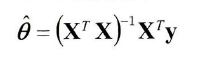

In [9]:
import numpy as np

X = 2*np.random.rand(100,1)
y = 4+3*X+np.random.randn(100,1)

In [10]:
# 정규방정식 사용해 세타 햇 계산
X_b = np.c_[np.ones((100,1)),X] # 모든 샘플에 x0=1 추가
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [11]:
theta_best

array([[4.1010708 ],
       [2.94111558]])

In [12]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new] # 모든 샘플에 x0=1추가
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.1010708 ],
       [9.98330196]])

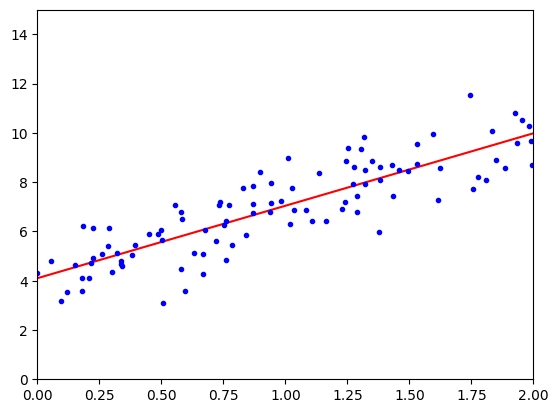

In [13]:
import matplotlib.pyplot as plt
plt.plot(X_new, y_predict, "r-")
plt.plot(X,y,"b.")
plt.axis([0,2,0,15])
plt.show()

In [14]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
print(lin_reg.intercept_, lin_reg.coef_)
lin_reg.predict(X_new)

[4.1010708] [[2.94111558]]


array([[4.1010708 ],
       [9.98330196]])

In [15]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.1010708 ],
       [2.94111558]])

In [16]:
np.linalg.pinv(X_b).dot(y)

array([[4.1010708 ],
       [2.94111558]])

유사역행렬: np.linalg.pinv() 함수 사용, 특잇값 분해라 부르는 표준 행렬 분해 기법 사용해 계산됨.

SVD: 훈련 세트 행렬 X를 3개의 행렬 곱셈으로 분해. 시그마+를 계산하기 위해 시그마를 구한 후 임계값보다 작은 수를 0으로 바꾸고 다른 값들을 역수로 치환함.

### 4.1.2 계산 복잡도
정규방정식은 (n+1)(n+1) 크기의 x.t*x의 역행렬 계산. 역행렬 계산하는 계산 복잡도는 보통 O(n^2.4)에서 O(n^3) 사이. 사이킷런의 LinearRegression 클래스가 사용하는 SVD 방법은 약 O(n^2)으로 특성 개수가 2배가 되면 계산 시간 4배가 됨. 학습된 선형 회귀 모델은 예측이 매우 빠름.

## 4.2 경사 하강법
특성이 매우 많고 훈련 샘플이 너무 많아 메모리에 모두 담을 수 없을 때 적합. 비용 함수를 최소화하기 위해 반복해서 파라미터 조정. 파라미터 백터 세타에 대해 비용 함수의 현재 그래디언트 계산. 그래디언트 감소하는 방향으로 진행. 그래디언트가 0이 되는 지점이 최솟값. 중요 파라미터 학습률은 스텝의 크기로 너무 작으면 수렴 위해 반복을 많이 진행해야 해 시간이 오래 걸리고 너무 크면 발산하게 되어 적절한 해법을 찾지 못하게 됨. 무작위 초기화로 알고리즘이 왼쪽에서 시작하면 전역 최솟값보다 덜 좋은 지역 최솟값에 수렴하고 오른쪽에서 시작하면 평탄한 지역을 지나기 위해 시간이 오래걸리고 일찍 멈춰 전역 최솟값에 도달하지 못함. 파라미터 공간은 모델 훈련이 비용 함수를 최소화하는 모델 파라미터의 조합을 찾는 일임을 설명해줌.

### 4.2.1 배치 경사 하강법
편도함수란 파라미터가 조금 변경될 때 비용 함수가 얼마나 바뀌는 지 계산 하는 것. 스텝의 크기를 결정하기 위해 그래디언트 벡터에 학습률을 곱함.

In [18]:
eta = 0.1 # 학습률
n_iterations = 1000
m=100
theta = np.random.randn(2,1) # 무작위 초기화

for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta)-y)
  theta = theta-eta*gradients

In [19]:
theta

array([[4.1010708 ],
       [2.94111558]])

### 4.2.2 확률적 경사 하강법
매 스텝에서 1개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그래디언트를 계산. 매 반복에서 다룰 데이터가 적어 빠르지만 불안정함. 비용함수가 최솟값에 다다를 때까지 위아래로 요동치며 평균적으로 감소. 학습률을 점진적으로 감소시켜 무작위성의 딜레마 해결.

In [21]:
n_epochs=50
t0,t1 = 5,50 # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
  return t0/(t+t1)

theta = np.random.randn(2,1) # 무작위 초기화

for epoch in range(n_epochs):
  for i in range(m):
    random_index = np.random.randint(m)
    xi = X_b[random_index:random_index+1]
    yi = y[random_index:random_index+1]
    gradients = 2*xi.T.dot(xi.dot(theta)-yi)
    eta = learning_schedule(epoch*m+i)
    theta = theta-eta*gradients

In [22]:
theta

array([[4.10487225],
       [2.97233415]])

In [23]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X,y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [25]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.02552096]), array([2.9369172]))

### 4.2.3 미니배치 경사 하강법
각 스텝에서 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그래디언트 계산. 행렬 연산에 최적화된 하드웨어, GPU를 사용해서 얻는 성능 향상이 큼. 미니배치를 어느 정도 크게 하면 SGD 보다 덜 불규칙하게 움직임. 미니배치 경사 하강법이 SGD 보다 최솟값에 더 가까이 도달 가능

## 4.3 다항 회귀
각 특성의 거듭제곱을 새로운 특성으로 추가하고 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련시키는 기법을 다항 회귀라고 함.

In [26]:
# 2차 방정식으로 비선형 데이터 생성
m=100
X=6*np.random.rand(m,1)-3
y=0.5*X**2+X+2+np.random.randn(m,1)

In [27]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-2.2647309])

In [28]:
X_poly[0]

array([-2.2647309 ,  5.12900604])

In [29]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly,y)
lin_reg.intercept_, lin_reg.coef_

(array([2.00533821]), array([[1.00745328, 0.47174531]]))

## 4.4 학습 곡선
고차 다항 회귀를 적용하면 훈련 데이터에 더 잘 맞게 학습 가능. 학습 곡선은 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기의 함수로 나타냄.

In [32]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X,y):
  X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)
  train_errors, val_errors=[],[]
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
  plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="훈련 세트")
  plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="검증 세트")

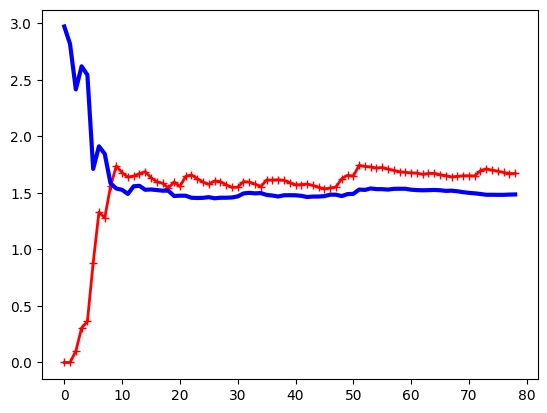

In [33]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X,y)

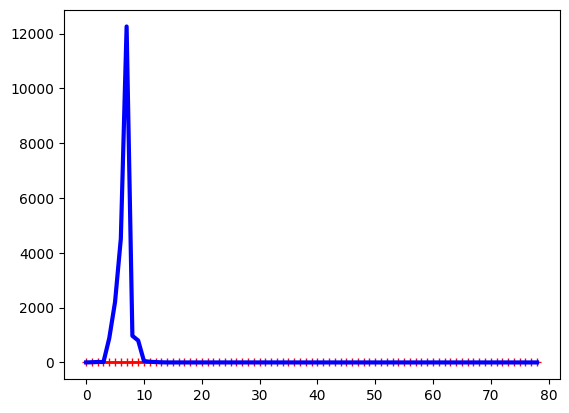

In [36]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X,y) # 오 그래프 매우 이상함

## 4.5 규제가 있는 선형 모델
모델을 규제하여 과대적합 감소. 다항식의 차수 감소 등, 모델의 가중치 제한으로 규제

### 4.5.1 릿지 회귀
모델의 가중치가 가능한 작게 유지되도록 노력. 규제항은 휸련하는 동안에만 비용 함수에 추가되며 훈련이 끝나면 모델 성능을 규제가 없는 성능 지표로 평가. 하이퍼 파라미터 알파는 모델을 얼마나 많이 규제할 지 조절. 알파는 0이면 릿지 회귀는 선형 회귀가 같아지며 알파가 아주 크면 모든 가중치가 0에 가까워져 수평선이 됨.

In [37]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X,y)

Ridge(alpha=1, solver='cholesky')

In [38]:
ridge_reg.predict([[1.5]])

array([[4.92982234]])

In [39]:
sgd_reg=SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.89944572])

### 4.5.2 라쏘 회귀
릿지 회귀처럼 비용함수에 규제항을 더하지만 l2 노름의 제곱을 2로 나눈 것 대신 가중치 벡터의 l1노름 사용. 라쏘 회귀는 자동적으로 특성선택을 하고 희소 모델을 만듦.

In [40]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([4.88460963])

### 4.5.3 엘라스틱넷
릿지 회귀와 라쏘 회귀를 절충한 모델. 규제항은 릿지와 회귀의 규제항을 더해 사용하며 혼합 정도는 혼합비율을 사용해 조절. r=0이면 릿지회귀와 같고 r=1이면 라쏘 회귀와 같음.

In [41]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([4.88534298])

### 4.5.4 조기 종료
검증 에러가 최솟값에 도달하면 훈련 중지. = 조기 종료

In [42]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2)
# 데이터 준비
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled=poly_scaler.transform(X_val)
sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005)
minimum_val_error=float("inf")
best_epoch=None
best_model=None

for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train) #훈련을 이어서 진행
  y_val_predict = sgd_reg.predict(X_val_poly_scaled)
  val_error = mean_squared_error(y_val, y_val_predict)
  if val_error < minimum_val_error:
    minimum_val_error = val_error
    best_epoch = epoch
    best_model = clone(sgd_reg)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

## 4.6 로지스틱 회귀
로지스틱 회귀는 샘플이 특정 클래스에 속할 확률을 추정하는데 사용됨. 추정 확률이 50퍼센트가 넘으면 해당 클래스에 속한다고 예측하는 이진 분류기

### 4.6.1 확률 추정
입력 특성의 가중치 합을 계산하여 결괏값의 로지스틱 출력. 로지스틱은 0과 1 사이의 값을 출력하는 시그모이드 함수.

### 4.6.2 훈련과 비용 함수
훈련의 목적은 양성 샘플에 대해 높은 확률을 추정하고 음성 샘플에 대해 낮은 확률을 추정하는 모델의 파라미터 벡터 찾기. 비용 함수는 볼록 함수이므로 경사 하강법이 전역 최솟값을 찾음.

### 4.6.3 결정 경계

In [43]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [44]:
X=iris["data"][:,3:] # 꽃잎 너비
y = (iris["target"]==2).astype(int) # iris-virginica이면 1 아니면0

In [45]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression()

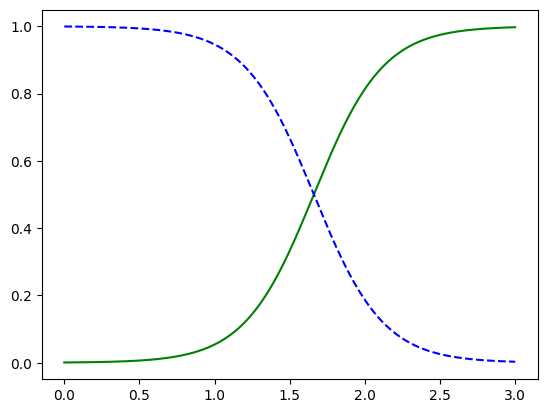

In [46]:
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:,0], "b--", label="Not Iris Virginica")

In [47]:
log_reg.predict([[1.7],[1.5]])

array([1, 0])

### 4.6.4 소프트맥스 회귀
여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화. 각 클래스에 대해 점수를 계산하고 소프트맥스 함수를 적용해 각 클래스의 확률 추정. 각 클래스는 자신만의 파라미터벡터가 있고 벡터들을 파라미터 행렬에 저장. 크로스 엔트로피 비용 함수를 최소화하는 것은 타깃 클래스에 대해 낮은 확률을 예측하는 모델 억제

In [48]:
X = iris["data"][:,(2,3)] # 꽃잎 길이, 너비
y = iris["target"]
softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial')

In [49]:
softmax_reg.predict([[5,2]])

array([2])

In [50]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])